In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import matplotlib.pyplot as plt
import keras
# use torch backend
import torch

import time
import jax
import jax.scipy as jscipy
import jax.numpy as jnp
import numpy as np
import pandas as pd



2024-08-29 12:30:33.495011: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 12:30:34.885582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 12:30:34.885636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 12:30:35.091144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 12:30:35.601216: I tensorflow/core/platform/cpu_feature_guar

In [14]:
def calc_grad__jax(y_T, phi, M, random_state=101):
    prng = np.random.RandomState(int(random_state))
    ysamp_TM = prng.normal(phi, 1, size=(T,M))
    r_T = np.mean(ysamp_TM, axis=1)

    def calc_logpdf_from_phi(phi):
        return jscipy.stats.norm.logpdf(ysamp_TM, phi, 1.0)
    calc_gradlogpdf_from_phi = jax.jacfwd(
        calc_logpdf_from_phi, argnums=0)
    g_lp_wrt_phi_TM = calc_gradlogpdf_from_phi(phi)
    g_r_wrt_phi_T = np.mean(g_lp_wrt_phi_TM * ysamp_TM, axis=1)

    def calc_loss_from_r(r_T, y_T):
        return jnp.mean(jnp.square(r_T - y_T))
    calc_loss_and_grad_wrt_r = jax.value_and_grad(calc_loss_from_r)
    loss, g_l_wrt_r_T = calc_loss_and_grad_wrt_r(r_T, y_T)
    g_l_wrt_phi = np.sum(g_l_wrt_r_T * g_r_wrt_phi_T)

    gdict = {   
        'g_loss_wrt_phi': g_l_wrt_phi,
        'g_loss_wrt_r_T': g_l_wrt_r_T,
        'g_r_wrt_phi_T': g_r_wrt_phi_T
    }
    return loss, gdict


def calc_grad__exact(y_T, phi, M, random_state=101):
    prng = np.random.RandomState(int(random_state))
    ysamp_TM = prng.normal(phi, 1, size=(T,M))
    r_T = np.mean(ysamp_TM, axis=1)

    loss = np.mean(np.square(r_T - y_T))

    g_r_wrt_phi_T = np.mean((ysamp_TM - phi) * ysamp_TM, axis=1)

    g_l_wrt_r_T = -2./T * (y_T - r_T)

    g_l_wrt_phi = np.sum(g_l_wrt_r_T * g_r_wrt_phi_T)

    gdict = {   
        'g_loss_wrt_phi': g_l_wrt_phi,
        'g_loss_wrt_r_T': g_l_wrt_r_T,
        'g_r_wrt_phi_T': g_r_wrt_phi_T
    }
    return loss, gdict


def calc_grad__torch(y_T, phi, M, random_state=101):
    
    y_T = torch.tensor(y_T)
    torch.manual_seed(random_state)

    #param_sized = phi*torch.ones(T)
    #distribution = torch.distributions.Normal(loc=param_sized, scale=1)
    prng = np.random.RandomState(int(random_state))
    ysamp_TM = prng.normal(phi, 1, size=(T,M))
    samples_MT = torch.tensor(ysamp_TM, requires_grad=True).transpose(1,0)
    phi = torch.tensor([phi], requires_grad=True)

    # calculate the log prob of those samples
    # log probs cannot be an argument, must be "baked" into function
    def get_log_probs_baked(param):
        param_sized = param*torch.ones(T)
        distribution = torch.distributions.Normal(loc=param_sized, scale=1)
        log_probs_MT = distribution.log_prob(samples_MT)

        return log_probs_MT
    
    jac_log_prob_MT = torch.autograd.functional.jacobian(get_log_probs_baked, (phi), strategy='forward-mode', vectorize=True)
    autodiff_grad_r_wrt_phi_MT = jac_log_prob_MT * torch.unsqueeze(samples_MT, dim=-1)
    autodiff_grad_r_wrt_phi_T = torch.mean(autodiff_grad_r_wrt_phi_MT, dim=0)

    action_samples_MT = samples_MT#distribution.sample(sample_shape=(M,))
    expected_action_T = torch.mean(action_samples_MT, dim=0)
    expected_action_T.requires_grad_(True).retain_grad()

    loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T)


    loss_T.backward()
    autodiff_grad_L_wrt_r_T = expected_action_T.grad
    #import pdb; pdb.set_trace()

    autodiff_grad_T = autodiff_grad_r_wrt_phi_T * torch.unsqueeze(autodiff_grad_L_wrt_r_T, 1)

    gdict = {   
        'g_loss_wrt_phi': torch.sum(autodiff_grad_T).detach().numpy(),
        'g_loss_wrt_r_T': autodiff_grad_L_wrt_r_T.detach().numpy(),
        'g_r_wrt_phi_T': autodiff_grad_r_wrt_phi_T.detach().numpy()
    }
    return torch.mean(loss_T).detach().numpy(), gdict

def calc_grad__exact_kyle_torch(y_T, phi, M, random_state=101):
    
    y_T = torch.tensor(y_T)
    torch.manual_seed(random_state)

    #param_sized = phi*torch.ones(T)
    #distribution = torch.distributions.Normal(loc=param_sized, scale=1)
    prng = np.random.RandomState(int(random_state))
    ysamp_TM = prng.normal(phi, 1, size=(T,M))
    samples_MT = torch.tensor(ysamp_TM, requires_grad=True).transpose(1,0)
    phi = torch.tensor([phi], requires_grad=True)

    
    analytical_grad_r_wrt_phi_MT = (samples_MT -phi)*samples_MT
    analytical_grad_r_wrt_phi_T = torch.mean(analytical_grad_r_wrt_phi_MT, dim=0)

    action_samples_MT = samples_MT#distribution.sample(sample_shape=(M,))
    expected_action_T = torch.mean(action_samples_MT, dim=0)
    expected_action_T.requires_grad_(True)

    loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T)
    analytical_grad_L_wrt_r_T = -2.0*(y_T - expected_action_T)
    analytical_grad_T = analytical_grad_r_wrt_phi_T * analytical_grad_L_wrt_r_T


    gdict = {   
        'g_loss_wrt_phi': torch.mean(analytical_grad_T).detach().numpy(),
        'g_loss_wrt_r_T': (analytical_grad_L_wrt_r_T/T).detach().numpy(),
        'g_r_wrt_phi_T': analytical_grad_r_wrt_phi_T.detach().numpy()
    }
    return torch.mean(loss_T).detach().numpy(), gdict

/tmp/ipykernel_2026675/1063884371.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vals_R = df[name][phi_val][key].values.astype(np.float32)


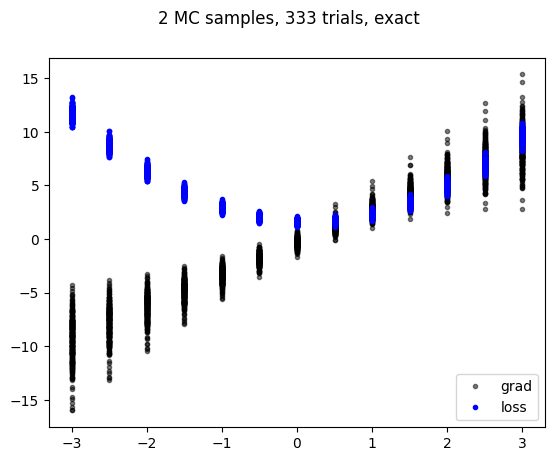

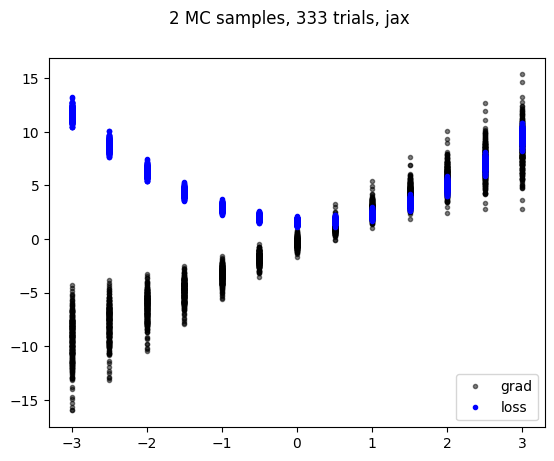

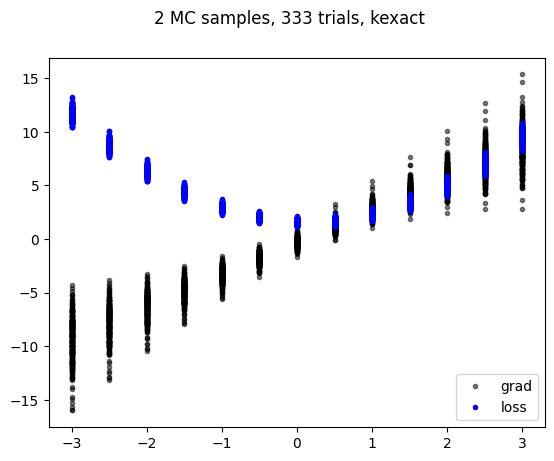

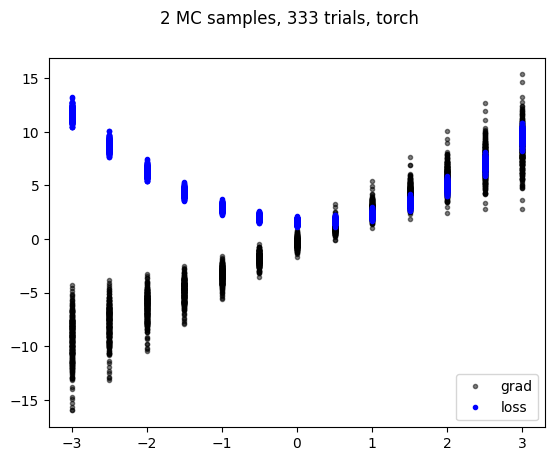

<Figure size 640x480 with 0 Axes>

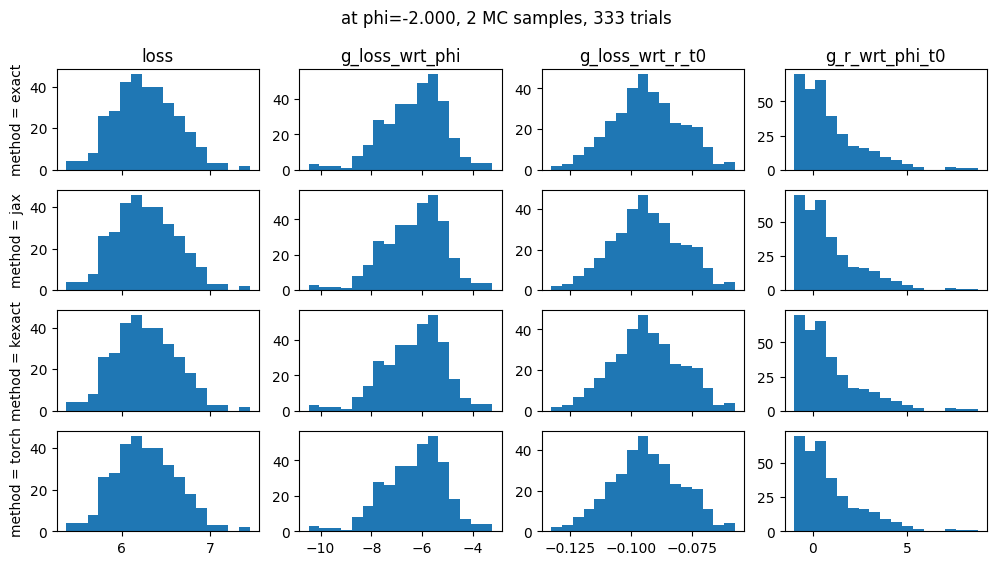

<Figure size 640x480 with 0 Axes>

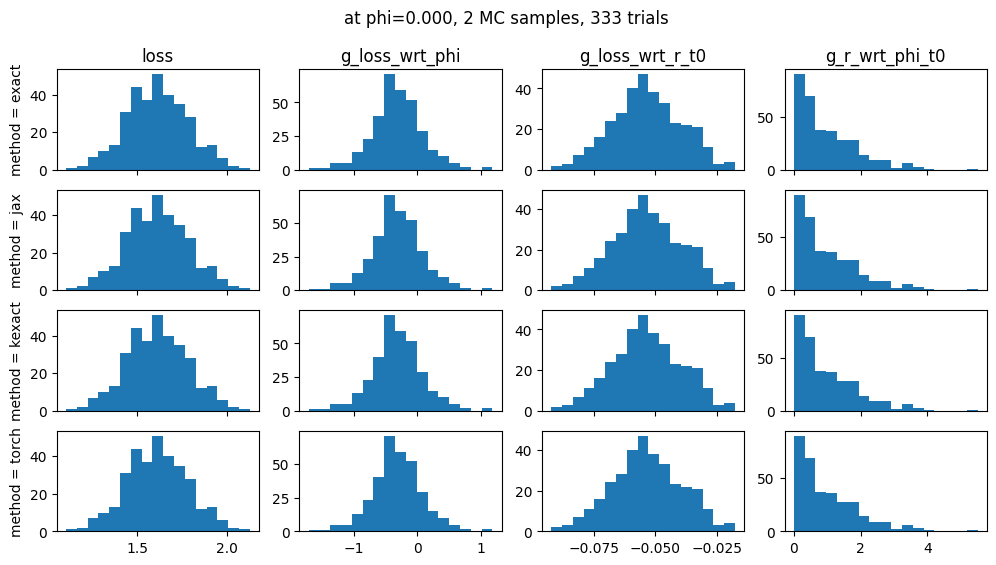

<Figure size 640x480 with 0 Axes>

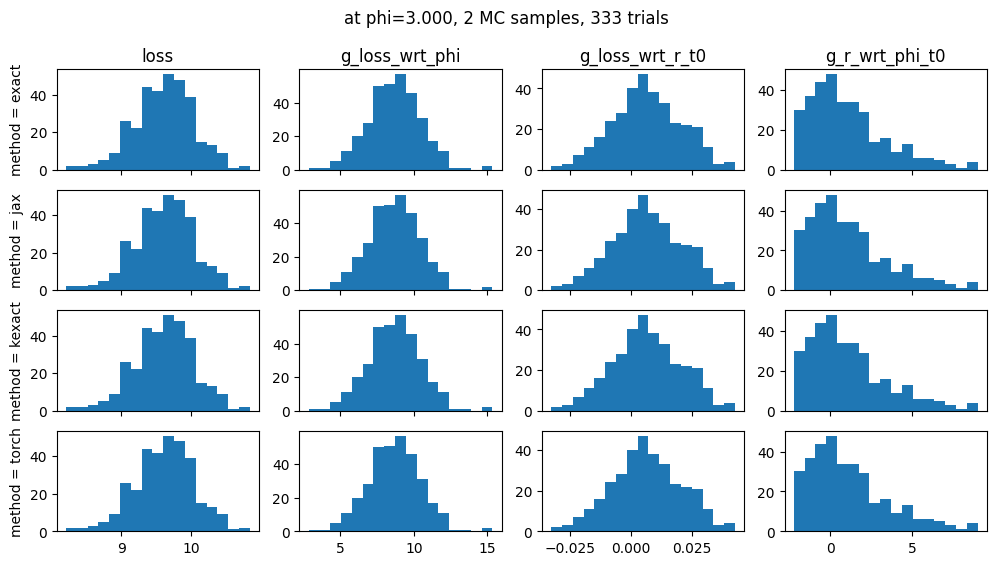

In [15]:
    T = 100
    M = 2
    R = 333

    prng = np.random.RandomState(101)
    y_T = prng.normal(0, 1, size=T)

    df = dict()
    for nickname, calc_grad in [
            ('exact', calc_grad__exact),
            ('jax', calc_grad__jax),
            ('kexact', calc_grad__exact_kyle_torch),
            ('torch', calc_grad__torch),
            ]:
        plt.figure()
        plt.suptitle(calc_grad.__name__)
        df[nickname] = dict()
        for phi in np.asarray(
                [-3, -2.5, -2, -1.5, -1, -.5, 0, .5, 1, 1.5, 2, 2.5, 3]):
            info_list = list()
            for rep in range(R):
                loss, gdict = calc_grad(y_T, phi, M, random_state=rep)
                info = dict(
                    loss=loss,
                    g_loss_wrt_phi=gdict['g_loss_wrt_phi'],
                    g_loss_wrt_r_t0=gdict['g_loss_wrt_r_T'][0],
                    g_r_wrt_phi_t0=gdict['g_r_wrt_phi_T'][0],
                    )
                
                info_list.append(info)
            cur_df = pd.DataFrame(info_list)
            df[nickname][phi] = cur_df.copy()

            cur_df['phi'] = float(phi)

            plt.plot(cur_df['phi'], cur_df['g_loss_wrt_phi'], 'k.',
                alpha=0.5,
                label='grad' if phi == 0 else None)
            plt.plot(cur_df['phi'], cur_df['loss'], 'b.', label='loss' if phi == 0 else None)
        plt.legend(loc='lower right')
        plt.suptitle("%d MC samples, %d trials, %s" % (
            M, R, nickname))
        plt.savefig('loss_vs_phi__%s.png' % nickname)

    for phi_val in [-2., 0., 3.]:
        plt.figure()
        _, axgrid = plt.subplots(
            nrows=4, ncols=4, sharex='col', sharey='col',
            figsize=(12, 6))
        for colid, key in enumerate(info.keys()):
            for rowid, name in enumerate(df.keys()):
                ax = axgrid[rowid, colid]
                vals_R = df[name][phi_val][key].values.astype(np.float32)
                ax.hist(vals_R, bins=17)
                if rowid == 0:
                    ax.set_title(key)
                if colid == 0:
                    ax.set_ylabel("method = " + name)
        plt.suptitle("at phi=%.3f, %d MC samples, %d trials" % (
            phi_val, M, R))
        plt.savefig('hist_panel_at_phi_%.3f.png' % phi_val)

In [40]:
cur_df

,loss,g_loss_wrt_phi,g_loss_wrt_r_t0,g_r_wrt_phi_t0,phi
0,9.796561733766671,506.27631260939495,-0.013053,[-0.08068293898281409],3.0
1,9.20189430675789,503.1910601827173,0.028119,[6.604773192299588],3.0
2,8.885015473673578,295.7394121281227,-0.010009,[-1.7509699568746973],3.0
3,9.168409504583225,344.7843307396318,-0.004463,[-1.1931842983055816],3.0
4,9.798508720007964,681.8362030693244,0.023810,[3.4973301812228534],3.0
...,...,...,...,...,...
328,9.402190430019148,459.34644523685586,0.004868,[1.1383206836856876],3.0
329,9.505333340607326,570.863266574625,0.005238,[-0.02595519295280624],3.0
330,10.016133143673716,632.5556808517215,-0.001041,[-0.7633576184734836],3.0
331,9.767325368307946,598.7130626707426,0.032269,[5.731119640821387],3.0


In [43]:
cur_df

,loss,g_loss_wrt_phi,g_loss_wrt_r_t0,g_r_wrt_phi_t0,phi
0,9.796561733766671,0.05062763126093949,-0.013053,[-0.08068293898281409],3.0
1,9.20189430675789,0.050319106018271734,0.028119,[6.604773192299588],3.0
2,8.885015473673578,0.02957394121281227,-0.010009,[-1.7509699568746973],3.0
3,9.168409504583225,0.03447843307396318,-0.004463,[-1.1931842983055816],3.0
4,9.798508720007964,0.06818362030693244,0.023810,[3.4973301812228534],3.0
...,...,...,...,...,...
328,9.402190430019148,0.045934644523685585,0.004868,[1.1383206836856876],3.0
329,9.505333340607326,0.057086326657462494,0.005238,[-0.02595519295280624],3.0
330,10.016133143673716,0.06325556808517215,-0.001041,[-0.7633576184734836],3.0
331,9.767325368307946,0.05987130626707426,0.032269,[5.731119640821387],3.0


In [31]:
cur_df

,loss,g_loss_wrt_phi,g_loss_wrt_r_t0,g_r_wrt_phi_t0,phi
0,9.796561733766671,0.05062763126093949,-0.013053,[-0.08068293898281409],3.0
1,9.20189430675789,0.050319106018271734,0.028119,[6.604773192299588],3.0
2,8.885015473673578,0.02957394121281227,-0.010009,[-1.7509699568746973],3.0
3,9.168409504583225,0.03447843307396318,-0.004463,[-1.1931842983055816],3.0
4,9.798508720007964,0.06818362030693244,0.023810,[3.4973301812228534],3.0
...,...,...,...,...,...
328,9.402190430019148,0.045934644523685585,0.004868,[1.1383206836856876],3.0
329,9.505333340607326,0.057086326657462494,0.005238,[-0.02595519295280624],3.0
330,10.016133143673716,0.06325556808517215,-0.001041,[-0.7633576184734836],3.0
331,9.767325368307946,0.05987130626707426,0.032269,[5.731119640821387],3.0


In [32]:
nickname

'torch'